# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [26]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
import seaborn as sns
from ast import literal_eval # converts string and converts it to list

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv",delimiter = ';', header =0)
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", delimiter = ";", header = 0)

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", delimiter=";")

In [39]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
total_entries = azdias.shape[0]
print(total_entries)
display(feat_info)

891221


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [40]:
display(azdias.head(n=5))
display(customers.head(n = 10))

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0
5,1,3,1,4.0,5,1,5,1,2,3,...,2.0,3.0,2.0,1.0,1.0,5.0,5.0,3.0,7.0,5.0
6,2,4,1,2.0,5,1,5,1,1,2,...,3.0,2.0,1.0,0.0,1.0,5.0,5.0,2.0,3.0,2.0
7,1,4,1,2.0,5,1,5,1,2,2,...,3.0,3.0,1.0,1.0,1.0,3.0,3.0,3.0,4.0,3.0
8,2,4,2,1.0,2,2,5,1,1,5,...,1.0,4.0,2.0,1.0,5.0,5.0,4.0,3.0,8.0,3.0
9,1,3,1,3.0,5,2,4,1,3,1,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,3.0,6.0,4.0


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [3]:
# Identify missing or unknown data values and convert them to NaNs.

def replace_missing_values_by_NaN(data):
    # X and XX are never used as "real" values, so they can be replaced in the whole data frame in one step
    data.replace(to_replace='XX', value=np.NaN, inplace=True)
    data.replace(to_replace='X', value=np.NaN, inplace=True)

    # Have a look at all types/values/columns
    for row in feat_info.itertuples():
        try:
            # Extract the values for the missing values
            missing_code = eval(row.missing_or_unknown)   
        except NameError:
            # There was an X or XX in the missing_or_unknown column
            # These values have been handled before
        
            # Now the other values have to be separated to replace them
            missing_code = row.missing_or_unknown[1:-1] # remove the brackets from the string
            missing_code = missing_code.split(",") # split the different entries
            # 'X' and 'XX' has been already replaced
            if 'X' in missing_code:
                missing_code.remove('X')
            if 'XX' in missing_code:
                missing_code.remove('XX')
        
    
        for missing_item in missing_code:
            data[row.attribute] = data[row.attribute].where(data[row.attribute]!=missing_item, other=np.NaN)
    return data
            
data = replace_missing_values_by_NaN(azdias)            
display(data.head(n=10))

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1.0,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,NaN,2.0,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,NaN,1.0,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,NaN,3.0,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,NaN,3.0,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

(array([ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  0., 40., 39.]),
 array([  2160. ,  91066.1, 179972.2, 268878.3, 357784.4, 446690.5,
        535596.6, 624502.7, 713408.8, 802314.9, 891221. ]),
 <a list of 10 Patch objects>)

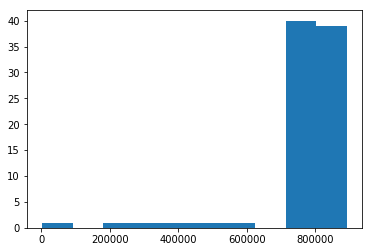

In [42]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# Count number of missing values in each column
# data.count() - Count non-NA cells for each column.
count_data = data.count()
plt.hist(count_data)
# Total lines in data: 891211
# cnt_count contains the name of the column and the number of values in there.
# In the histogram can be seen, that there are most columns have more than 750.000 entries

In [43]:
# Investigate patterns in the amount of missing data in each column.
print("Variable             |Missing| Total| Missing/Total (in %)\n")
nb_features = data.shape[0]
for column, value in count_data.iteritems():
    print("{:21s}|{:7d}|{}|{}".format(column, value, nb_features, (value/nb_features)*100))


Variable             |Missing| Total| Missing/Total (in %)

AGER_TYP             | 205378|891221|23.044564703928653
ALTERSKATEGORIE_GROB | 888340|891221|99.67673562449718
ANREDE_KZ            | 891221|891221|100.0
CJT_GESAMTTYP        | 886367|891221|99.4553539470008
FINANZ_MINIMALIST    | 891221|891221|100.0
FINANZ_SPARER        | 891221|891221|100.0
FINANZ_VORSORGER     | 891221|891221|100.0
FINANZ_ANLEGER       | 891221|891221|100.0
FINANZ_UNAUFFAELLIGER| 891221|891221|100.0
FINANZ_HAUSBAUER     | 891221|891221|100.0
FINANZTYP            | 891221|891221|100.0
GEBURTSJAHR          | 498903|891221|55.97971771311493
GFK_URLAUBERTYP      | 886367|891221|99.4553539470008
GREEN_AVANTGARDE     | 891221|891221|100.0
HEALTH_TYP           | 780025|891221|87.52318448510526
LP_LEBENSPHASE_FEIN  | 793589|891221|89.04514144078742
LP_LEBENSPHASE_GROB  | 796649|891221|89.3884906212937
LP_FAMILIE_FEIN      | 813429|891221|91.2713008333511
LP_FAMILIE_GROB      | 813429|891221|91.2713008333511
LP_STAT

In [4]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

def remove_outliers_in_columns_find(data, minimum_data_entries = 700000):
    print("Original Shape: ",data.shape)
    # Count the number of entries
    count_data = data.count()
    # The cnt_data is now sorted to remove the columns with a lot of NaN-values
    count_data.sort_values(inplace = True)
    keys_few_data = [] 
    for column, value in count_data.iteritems():
        if value < minimum_data_entries:
            print(column, value)
            keys_few_data.append(column)
            data.drop(column, 1, inplace = True)
        else:
            # count_data is sorted, so as soon as one value is bigger than the limit, all other values will be as well
            break
            
    data.reset_index(drop = True, inplace =True)
    print("Final Shape: ",data.shape)
    return data, keys_few_data

def remove_outliers_in_columns_use(data, keys_few_data):
    print("Original Shape: ",data.shape) 
    for column in keys_few_data:
        print("<"+column+">")
        data.drop(column, 1, inplace = True)
    
    data.reset_index(drop = True, inplace =True)
    print("Final Shape: ",data.shape)
    return data



In [5]:
minimum_data_entries = 700000
data, keys_few_data = remove_outliers_in_columns_find(data, minimum_data_entries)
#remove_outliers_in_columns_use(data, keys_few_data)

Original Shape:  (891221, 85)
TITEL_KZ 2160
AGER_TYP 205378
KK_KUNDENTYP 306609
KBA05_BAUMAX 414697
GEBURTSJAHR 498903
ALTER_HH 580954
Final Shape:  (891221, 79)


#### Discussion 1.1.2: Assess Missing Data in Each Column
As it can be seen in the histogram, some columns have few data points. There is a big gap between the columns which have over 700.000 values. So this value has been chosen to decide which columns are dropped from the data set.

The following columns are dropped:
- TITEL_KZ -> only few people have an academic title
- AGER_TYP -> Are person best agers? This information can be retrieved by analysing ALTERSKATEGORIE_GROB and other person related features
- KK_KUNDENTYP -> Consumer pattern over past 12 months
- KBA05_BAUMAX -> represents the most common building type within the microcell
- GEBURTSJAHR -> year of birth, the information is represented in a more general way by ALTERSKATEGORIE_GROB
- ALTER_HH -> Household-level features, Birthdate of head of household


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

Remaining columns:  79
643174    30
732775    30
472919    31
88864     32
88857     32
276968    32
276969    32
88846     32
864184    32
696170    32
277016    32
277025    32
277032    32
696149    32
829017    32
829020    32
696139    32
696131    32
696126    32
696115    32
829036    32
88794     32
88766     32
88763     32
864196    32
88868     32
660880    32
88870     32
88961     32
88960     32
          ..
349078    79
349079    79
349081    79
349083    79
349084    79
349071    79
349052    79
349051    79
349050    79
349027    79
349028    79
349029    79
349030    79
349031    79
349032    79
349033    79
349034    79
349035    79
349036    79
349037    79
349041    79
349043    79
349044    79
349045    79
349046    79
349047    79
349048    79
349049    79
349024    79
891220    79
Length: 891221, dtype: int64


(array([4.60750e+04, 2.80380e+04, 5.03100e+03, 1.40160e+04, 1.55000e+02,
        8.29000e+02, 9.53300e+03, 1.28010e+04, 7.76340e+04, 6.97109e+05]),
 array([30. , 34.9, 39.8, 44.7, 49.6, 54.5, 59.4, 64.3, 69.2, 74.1, 79. ]),
 <a list of 10 Patch objects>)

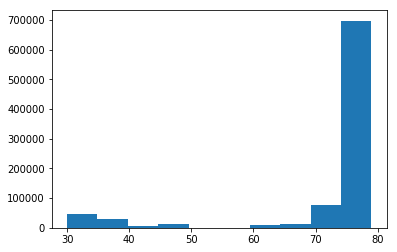

In [46]:
# How much data is missing in each row of the dataset?
total_columns = data.shape[1]
print("Remaining columns: ",total_columns)
count_row = data.count(axis = 1)# axis: If 0 - counts are generated for each column. If 1 or ‘columns’ counts are generated for each row.
count_row.sort_values(inplace = True)

#count_row.drop(0, inplace=True)
print(count_row[:][:])

#count_row_transposed = count_row.transpose()
#cols = count_row[-1:] + count_row[:-1]
#print(cols)

plt.hist(count_row)
# TODO: Turn plot, so that it's representative



In [6]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

def remove_outliers_in_rows(data, minimum_data_entries):
    print(" Original shape of data: {}".format(data.shape))
    rows_below_threshold = data.copy(deep = True)
    rows_above_threshold = data.copy(deep = True)

    # Store which values are below/above threshold
    keys_below_threshold = []
    keys_above_threshold = []
    
    count_row = data.count(axis = 1)# axis: If 0 - counts are generated for each column. If 1 or ‘columns’ counts are generated for each row.
    count_row.sort_values(inplace = True)

    for key in count_row.keys():
        #print("Key: {}, Value: {}".format(key, count_row.get(key)))
        #print(data.iloc[[key]])
        if count_row.get(key) < limit:
            keys_below_threshold.append(key)
            #rows_above_threshold.drop(key, inplace = True)
        else:
            keys_above_threshold.append(key)

    rows_above_threshold.drop(keys_below_threshold, inplace = True)
    rows_above_threshold.reset_index(drop = True, inplace =True)
    rows_below_threshold.drop(keys_above_threshold, inplace = True)
    rows_below_threshold.reset_index(drop = True, inplace =True)
    print("{} data rows have been dropped as they contained less than {} data entries. \n"\
          "In total, there are {} rows for further calculations.".format(rows_below_threshold.shape[0],
                                                                        minimum_data_entries,
                                                                        rows_above_threshold.shape[0]))
    return rows_above_threshold, rows_below_threshold, keys_below_threshold
    #print(rows_below_threshold.shape)
limit = 32 
rows_above_threshold, rows_below_threshold, keys_below_threshold = remove_outliers_in_rows(data, limit)

 Original shape of data: (891221, 79)
3 data rows have been dropped as they contained less than 32 data entries. 
In total, there are 891218 rows for further calculations.


In [48]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
rows_below_threshold.head()
#TODO


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,1.0,1,NaN,5,1,5,2,3,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3.0,1,NaN,2,5,3,5,5,2,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,2,NaN,3,5,3,5,5,2,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Discussion 1.1.3: Assess Missing Data in Each Row
268012 lines of the dataset are not completely filled. 
Some of the entries may be redundant. This can be especially true for columns of the same "main category". In this case, removing the row will not make much difference.
To keep mixed and numerical columns, the limit was set to 32.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [7]:
# How many features are there of each data type?
print("Number of original features per data type: \n{}".format(feat_info.type.value_counts()))
print("The numbers related to the original data without the dropped features!")
### Remove the columns which have to few data points
#print(feat_info.shape)
def update_feat_info(feat_info, keys_few_data):
    feat_info_updated = feat_info.copy(deep=True)
    for key in keys_few_data:
        feat_info_updated = feat_info_updated[feat_info_updated.attribute != key]
    return feat_info_updated

feat_info_updated = update_feat_info(feat_info, keys_few_data)
#print(feat_info_updated.shape)      
print("Number of used features per data type: \n{}".format(feat_info_updated.type.value_counts()))    

Number of original features per data type: 
ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64
The numbers related to the original data without the dropped features!
Number of used features per data type: 
ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [8]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
def extract_columns_types(feat_info):
    ordinal_columns = feat_info_updated[feat_info.type == 'ordinal']
    categorical_columns = feat_info_updated[feat_info.type == 'categorical']
    mixed_columns = feat_info_updated[feat_info.type == 'mixed']
    numeric_columns = feat_info_updated[feat_info.type == 'numeric']
    return ordinal_columns, categorical_columns, mixed_columns, numeric_columns

ordinal_columns, categorical_columns, mixed_columns, numeric_columns = extract_columns_types(feat_info_updated)
print(ordinal_columns.attribute.shape)
print(categorical_columns.attribute.shape)
print(mixed_columns.attribute.shape)
print(numeric_columns.attribute.shape)
print("These numbers should be similar to the results of the previous cell!")


(49,)
(18,)
(6,)
(6,)
These numbers should be similar to the results of the previous cell!


#### Discussion 1.2.1: Re-Encode Categorical Features

Discussion can be found below the next code cell

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [9]:
# Re-encode categorical variable(s) to be kept in the analysis.
# For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
#rows_above_threshold
#print(ordinal_columns.attribute)
#print(rows_above_threshold.value_counts())
#labels_list = list(rows_above_threshold)
#print(type(labels_list))
def reencode_features(data, oridnal_columns, numeric_columns, categorical_columns, mixed_columns):
    #assert data.shape == (623209, 79), "Not using the original data"
   
    print("Original shape: {}".format(data.shape))

    for column, value in data.iteritems():
     
        if column in ordinal_columns.attribute.values or column in numeric_columns.attribute.values:
            # For numeric and interval data, these features can be kept without changes.
            pass
        elif column in categorical_columns.attribute.values:
            #print("CATEGORICAL - ", column)
            if value.value_counts().shape[0] == 2:
                
                if column == "OST_WEST_KZ":
                    # Replace values given in to_replace with value.
                    data.replace(to_replace = 'W', value = 1, inplace = True)
                    data.replace(to_replace = 'O', value = 0, inplace = True)
                                               #data[row.attribute]!=missing_item, other=np.NaN)
                else:
                    # For binary (two-level) categoricals that take numeric values, 
                    # you can keep them without needing to do anything.
                    pass
            else:
                # For multi-level categoricals (three or more values), 
                # you can choose to encode the values using multiple dummy variables 
                # (e.g. via OneHotEncoder), or (to keep things straightforward) just drop them from the analysis. 
                
                    #tmp = pd.get_dummies(value, prefix = column)
                    #if colum:
                        
                    #    tmp = pd.concat([t])
                    # Column makes problems later on
                    #data.drop(column, axis=1, inplace=True)
                #else:
                    tmp = pd.get_dummies(value, prefix = column)
                    
                    if column == "GEBAEUDETYP" and tmp.shape[1] < 7:
                        # In the customer data there is no column GEBAEUDE_TYP_5.0
                        print("adding Gebauedetyp_5.0, length: ", tmp.shape)
                        additional = {'GEBAEUDETYP_5.0': np.zeros(tmp.shape[1])}
                        additional = pd.DataFrame(data=additional)
                        tmp = pd.concat([tmp,additional], axis = 1)
                    # Replace old column by dummy variables
                    data.drop(column, axis=1, inplace=True)
                    data = pd.concat([data, tmp], axis=1)
                    # Comment line above(.concat) and .get_dummies, if the columns should be only dropped

        elif column in mixed_columns.attribute.values:
            #print("MIXED - ", column)
            if column == "CAMEO_INTL_2015":
                # combines information on two axes: wealth and life stage. 
                # Break up the two-digit codes by their 'tens'-place and 'ones'-place digits 
                # into two new ordinal variables (which, for the purposes of this project, 
                # is equivalent to just treating them as their raw numeric values).
                wealth = []
                life =[]
                for item in value:
                    if np.isnan(float(item)):
                        wealth.append(np.NaN)
                        life.append(np.NaN)
                    else:
                        wealth.append(int(item[0]))
                        life.append(int(item[1]))
                # Replace old column by dummy variables
                data.drop(column, axis=1, inplace=True)
                tmp = {'CAMEO_INTL_2015_WEALTH': wealth, 'CAMEO_INTL_2015_LIFE': life}
                tmp = pd.DataFrame(data=tmp)
                data = pd.concat([data, tmp], axis=1)
            elif column == "PRAEGENDE_JUGENDJAHRE":
                # "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: 
                # - generation by decade, -> generate an interval-type variable for decade,
                # - movement (mainstream vs. avantgarde) -> generate a binary variable
                # - nation (east vs. west). -> There aren't enough levels to disentangle east from west
                avantgarde = []
                generation = []
                for item in value:
                
                    # MOVEMENT
                    if np.isnan(float(item)):
                        avantgarde.append(np.NaN)
                    elif item in [2,4,6,7,9,11,13,15]:
                        # Avantgarde
                        avantgarde.append(1)
                    elif item in [1,3,5,8,10,12,14]:
                        # Mainstream
                        avantgarde.append(0)
                    else:
                        print("MOVEMENT - This label should not be in the list: {}".format(item))
                
                    # GENERATION
                    if np.isnan(float(item)):
                        generation.append(np.NaN)
                    elif item in [1,2]:
                        generation.append(40)
                    elif item in [3,4]:
                        generation.append(50)
                    elif item in [5,6,7]:
                        generation.append(60)
                    elif item in [8,9]:
                        generation.append(70)
                    elif item in [10,11,12,13]:
                        generation.append(80)
                    elif item in [14,15]:
                        generation.append(90)
                    else:
                        print("GENERATION - This label should not be in the list: {}".format(item))
                data.drop(column, axis=1, inplace=True)
                tmp = {'JUGENDJAHRE_AVANTGARDE': avantgarde, 'JUGENDJAHRE_GENERATION': generation}
                tmp = pd.DataFrame(data=tmp)
                data = pd.concat([data, tmp], axis=1)
            
            else:
                # remove the other mixed-type features
                data.drop(column, axis=1, inplace=True)
            
        else:
            print("There should be no column in another format: {}".format(column))
    data.reset_index(drop = True, inplace =True)
    print("Shape after adding dummy_variables: {}".format(data.shape))
    return data

# Uncomment the following 3 lines for debugging
#rows_above_threshold = data.copy(deep = True)
#rows_above_threshold.drop(keys_below_threshold, inplace = True)
#rows_above_threshold.reset_index(drop = True, inplace =True)
data = reencode_features(rows_above_threshold, ordinal_columns, numeric_columns, categorical_columns, mixed_columns)

#list(rows_above_threshold)


Original shape: (891218, 79)
Shape after adding dummy_variables: (891218, 192)


#### Discussion 1.2.1 & 1.2.2: Re-Encode Categorical Features & Engineer Mixed-Type Features

In the dataset are 18 categorical features. It would be a great loss, if all these columns would only be removed of the data set. So, these values are OneHotEncoded. The column OST_WEST_KZ has only two values, but they are not stored in binary format. So this column is changed to represent its values in a binary format.

For the mixed value columns, only the two columns 'CAMEO_INTL_2015' and 'PRAEGENDE_JUGENDJAHRE' have been processed. The other columns have been dropped.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [52]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)


In [53]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [60]:
def clean_data(df, feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    data = replace_missing_values_by_NaN(df)
    
    # remove selected columns and rows, ...
    data = remove_outliers_in_columns_use(data, keys_few_data)
    rows_above_threshold, rows_below_threshold, _ = remove_outliers_in_rows(data, minimum_data_entries = 32)
    
    # select, re-encode, and engineer column values.
    feat_info_updated = update_feat_info(feat_info, keys_few_data)
    print("Number of used features per data type: \n{}".format(feat_info_updated.type.value_counts()))   
    ordinal_columns, categorical_columns, mixed_columns, numeric_columns = extract_columns_types(feat_info_updated)
    data_cleaned = reencode_features(rows_above_threshold, ordinal_columns, numeric_columns, categorical_columns, mixed_columns)
    few_data_cleaned = reencode_features(rows_below_threshold, ordinal_columns, numeric_columns, categorical_columns, mixed_columns)
    # Return the cleaned dataframe.
    return data_cleaned, few_data_cleaned

customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", delimiter = ";", header = 0)
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", delimiter=";")
clean_customers, customers_below_threshold = clean_data(customers, feat_info)
    

Original Shape:  (191652, 85)
<TITEL_KZ>
<AGER_TYP>
<KK_KUNDENTYP>
<KBA05_BAUMAX>
<GEBURTSJAHR>
<ALTER_HH>
Final Shape:  (191652, 79)
 Original shape of data: (191652, 79)
3 data rows have been dropped as they contained less than 32 data entries. 
In total, there are 191649 rows for further calculations.
Number of used features per data type: 
ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64
Original shape: (191649, 79)
adding Gebauedetyp_5.0, length:  (191649, 6)
Shape after adding dummy_variables: (191649, 192)
Original shape: (3, 79)
adding Gebauedetyp_5.0, length:  (3, 0)
Shape after adding dummy_variables: (3, 66)


In [61]:
data = pd.read_csv("Udacity_AZDIAS_Subset.csv", delimiter = ";", header = 0)
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", delimiter=";")
data, data_below_threshold = clean_data(data, feat_info)

Original Shape:  (891221, 85)
<TITEL_KZ>
<AGER_TYP>
<KK_KUNDENTYP>
<KBA05_BAUMAX>
<GEBURTSJAHR>
<ALTER_HH>
Final Shape:  (891221, 79)
 Original shape of data: (891221, 79)
3 data rows have been dropped as they contained less than 32 data entries. 
In total, there are 891218 rows for further calculations.
Number of used features per data type: 
ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64
Original shape: (891218, 79)
Shape after adding dummy_variables: (891218, 192)
Original shape: (3, 79)
adding Gebauedetyp_5.0, length:  (3, 0)
Shape after adding dummy_variables: (3, 67)


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [12]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
def replace_NaNs_by_mean(data):
    print("replace_NaNs_by_mean - begin: ",data.shape)
    for column, value in data.iteritems():
        #print(value.to_frame().iloc[:,0].value_counts())
        if value.to_frame().iloc[:,0].isnull().values.any():
            #print("column: {} - empty values", column)
            column_mean = value.to_frame().iloc[:,0].mean()
            data.fillna(column_mean, inplace=True)
    print("replace_NaNs_by_mean - end:" ,data.shape)
    return data
            # NaN values have been replaced by the mean of the column

In [62]:
# Apply feature scaling to the general population demographics data.
def create_feature_scaling(data, column_names):
    data = replace_NaNs_by_mean(data)
    scaler = StandardScaler()
    print(data.shape)
    data = scaler.fit_transform(data)
    # data_transformed is a numpy array -> convert it back to a pd.DataFrame
    data_transformed = pd.DataFrame(data,columns=column_names)
    print(data_transformed.shape)
    return data_transformed, scaler


def apply_feature_scaling(scaler, data, column_names):
    print(len(column_names))
    data = replace_NaNs_by_mean(data)
    print(data.shape)
    data = scaler.transform(data)
    # data_transformed is a numpy array -> convert it back to a pd.DataFrame
    data_transformed = pd.DataFrame(data,columns=column_names)
    return data_transformed

data_transformed, scaler = create_feature_scaling(data, data.columns)
#print(data_transformed.head())
print("aaply_feature_scaling")
tmp = apply_feature_scaling(scaler, data, data.columns)

replace_NaNs_by_mean - begin:  (891218, 192)
replace_NaNs_by_mean - end: (891218, 192)
(891218, 192)


/home/meli/miniconda3/envs/env-conda-3-7/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/meli/miniconda3/envs/env-conda-3-7/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


(891218, 192)
aaply_feature_scaling
192
replace_NaNs_by_mean - begin:  (891218, 192)
replace_NaNs_by_mean - end: (891218, 192)
(891218, 192)


/home/meli/miniconda3/envs/env-conda-3-7/lib/python3.6/site-packages/ipykernel_launcher.py:17: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.


### Discussion 2.1: Apply Feature Scaling

The data still contained NaN values. To reduce their impact on the following computations, the NaNs have been replaced by the mean of their column.
The StandardScaler is used with its default parameters, so there is no additional discussion needed.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [58]:
# Apply PCA to the data.
pca_all = PCA()
X_pca = pca_all.fit_transform(data_transformed)


In [14]:
# Method copied out of helper_function.py used by the labs in the chapter PCA
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

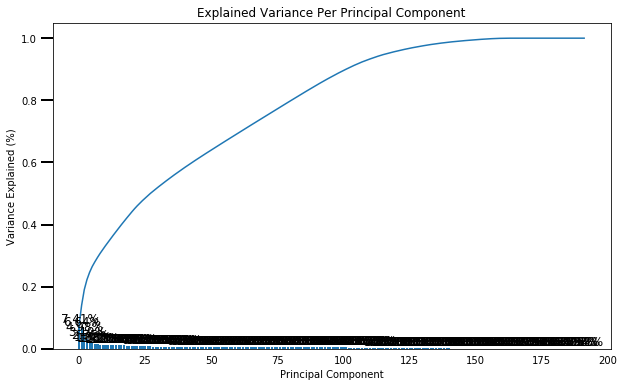

In [60]:
# Investigate the variance accounted for by each principal component.
scree_plot(pca_all)

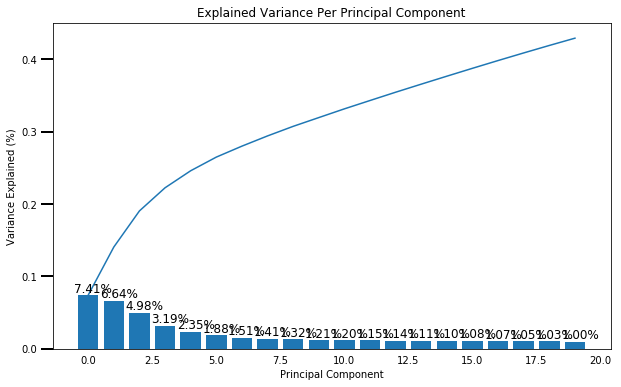

In [15]:
# Re-apply PCA to the data while selecting for number of components to retain.
# My PCA should contain 40 % of the variance, so the first 20 components are used
pca_final = PCA(n_components = 20)
X_pca = pca_final.fit_transform(data_transformed)
scree_plot(pca_final)

### Discussion 2.2: Perform Dimensionality Reduction

The data is reduced to contain only 40 % of the original variance. This is done by reducing the number of components to 20.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [49]:
#def map_weights_to_features_names_pca(nb_component, )

# Base Method copied out of helper_function.py used by the labs in the chapter PCA and then adapted
def pca_map_weights_to_features_names(nb_component, full_dataset, pca):
    '''
    Input:
    - nb_component - if you want to get the first component, enter a 1
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    ## Create a bar plot visualization
    #fig, ax = plt.subplots(figsize = (14,8))

    ## Plot the feature weights as a function of the components
    #components.plot(ax = ax, kind = 'bar');
    #ax.set_ylabel("Feature Weights")
    #ax.set_xticklabels(dimensions, rotation=0)


    ## Display the explained variance ratios
    #for i, ev in enumerate(pca.explained_variance_ratio_):
    #    ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

    # Return a concatenated DataFrame
    df_concat = pd.concat([variance_ratios, components], axis = 1)
    # Extract wished component
    linked_values = df_concat.iloc[nb_component-1]
    # TODO - Do I have to calculate the absolute values? 
    # -> It doesn't matter in which direction the values influence
    #linked_values = linked_values.abs()
    linked_values_sorted = linked_values.sort_values(inplace = False)
    return linked_values_sorted

pca_map_weights_to_features_names(1, data_transformed, pca_final)


FINANZ_MINIMALIST        -0.1698
MOBI_REGIO               -0.1622
MIN_GEBAEUDEJAHR         -0.1513
KBA05_GBZ                -0.1505
NATIONALITAET_KZ_1.0     -0.1443
INNENSTADT               -0.1369
WOHNDAUER_2008           -0.1360
PLZ8_GBZ                 -0.1287
GEBAEUDETYP_RASTER       -0.1229
GEBAEUDETYP_1.0          -0.1192
KBA13_ANZAHL_PKW         -0.1187
ALTERSKATEGORIE_GROB     -0.1148
KONSUMNAEHE              -0.1134
SEMIO_VERT               -0.1123
FINANZ_VORSORGER         -0.1109
PLZ8_ANTG1               -0.1102
LP_STATUS_GROB_4.0       -0.1066
LP_STATUS_FEIN_9.0       -0.1060
BALLRAUM                 -0.1058
LP_STATUS_FEIN_10.0      -0.0995
LP_STATUS_GROB_5.0       -0.0995
GREEN_AVANTGARDE         -0.0994
KBA05_ANTG1              -0.0977
ZABEOTYP_1               -0.0933
CAMEO_INTL_2015_LIFE     -0.0933
FINANZTYP_2              -0.0870
SEMIO_ERL                -0.0869
CAMEO_DEUG_2015_2        -0.0823
JUGENDJAHRE_GENERATION   -0.0809
FINANZTYP_6              -0.0759
          

In [51]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_map_weights_to_features_names(1, data_transformed, pca_final)

FINANZ_MINIMALIST        -0.1698
MOBI_REGIO               -0.1622
MIN_GEBAEUDEJAHR         -0.1513
KBA05_GBZ                -0.1505
NATIONALITAET_KZ_1.0     -0.1443
INNENSTADT               -0.1369
WOHNDAUER_2008           -0.1360
PLZ8_GBZ                 -0.1287
GEBAEUDETYP_RASTER       -0.1229
GEBAEUDETYP_1.0          -0.1192
KBA13_ANZAHL_PKW         -0.1187
ALTERSKATEGORIE_GROB     -0.1148
KONSUMNAEHE              -0.1134
SEMIO_VERT               -0.1123
FINANZ_VORSORGER         -0.1109
PLZ8_ANTG1               -0.1102
LP_STATUS_GROB_4.0       -0.1066
LP_STATUS_FEIN_9.0       -0.1060
BALLRAUM                 -0.1058
LP_STATUS_FEIN_10.0      -0.0995
LP_STATUS_GROB_5.0       -0.0995
GREEN_AVANTGARDE         -0.0994
KBA05_ANTG1              -0.0977
ZABEOTYP_1               -0.0933
CAMEO_INTL_2015_LIFE     -0.0933
FINANZTYP_2              -0.0870
SEMIO_ERL                -0.0869
CAMEO_DEUG_2015_2        -0.0823
JUGENDJAHRE_GENERATION   -0.0809
FINANZTYP_6              -0.0759
          

In [52]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print(pca_map_weights_to_features_names(2, data_transformed, pca_final))


KBA05_ANTG1              -0.1965
ANZ_TITEL                -0.1922
SOHO_KZ                  -0.1916
OST_WEST_KZ              -0.1821
JUGENDJAHRE_AVANTGARDE   -0.1784
ANZ_HH_TITEL             -0.1725
PLZ8_ANTG1               -0.1713
FINANZTYP_4              -0.1554
LP_STATUS_FEIN_5.0       -0.1507
MOBI_REGIO               -0.1445
ANZ_PERSONEN             -0.1211
KBA05_GBZ                -0.1156
FINANZ_UNAUFFAELLIGER    -0.1115
GFK_URLAUBERTYP_5.0      -0.1077
FINANZ_MINIMALIST        -0.1012
KBA05_ANTG4              -0.0956
FINANZ_ANLEGER           -0.0953
KONSUMNAEHE              -0.0925
CJT_GESAMTTYP_6.0        -0.0914
VERS_TYP                 -0.0877
LP_STATUS_GROB_2.0       -0.0855
CAMEO_INTL_2015_LIFE     -0.0737
SEMIO_KRIT               -0.0735
SEMIO_REL                -0.0698
KBA05_ANTG2              -0.0691
LP_STATUS_GROB_5.0       -0.0606
LP_STATUS_FEIN_10.0      -0.0606
PLZ8_GBZ                 -0.0600
ONLINE_AFFINITAET        -0.0600
LP_STATUS_GROB_4.0       -0.0557
          

In [53]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print(pca_map_weights_to_features_names(3, data_transformed, pca_final))


SEMIO_TRADV              -0.2291
SEMIO_KULT               -0.2087
FINANZ_SPARER            -0.2050
SEMIO_PFLICHT            -0.1995
JUGENDJAHRE_GENERATION   -0.1954
SEMIO_REL                -0.1780
ONLINE_AFFINITAET        -0.1660
SEMIO_RAT                -0.1619
FINANZ_ANLEGER           -0.1514
FINANZ_UNAUFFAELLIGER    -0.1505
FINANZTYP_1              -0.1436
SEMIO_FAM                -0.1353
SEMIO_MAT                -0.1266
ZABEOTYP_4               -0.1224
SEMIO_SOZ                -0.1122
ZABEOTYP_5               -0.1050
LP_STATUS_FEIN_2.0       -0.1024
MIN_GEBAEUDEJAHR         -0.0801
SEMIO_VERT               -0.0781
GFK_URLAUBERTYP_9.0      -0.0774
SHOPPER_TYP_0.0          -0.0752
ZABEOTYP_1               -0.0746
FINANZTYP_3              -0.0717
LP_FAMILIE_GROB_4.0      -0.0716
CJT_GESAMTTYP_4.0        -0.0685
INNENSTADT               -0.0675
KBA13_ANZAHL_PKW         -0.0625
KBA05_GBZ                -0.0596
PLZ8_GBZ                 -0.0590
GEBAEUDETYP_RASTER       -0.0562
          

### Discussion 2.3: Interpret Principal Components
If you have a look at the most influencing columns, you can see 3 big topics:
- all fields with "SEMIO" in the title. They are related with the personality type of a person
- all fields with "FINANZ" in the title are related to the financial type of the person. How easy does this person spend money?
- The values of EWDICHTE, ORTSGR_KLS9 and MOBI_REGIO contain information in which region a person lives. In a city or in a village?

Another point which can be found on high positions is ALTERSKATEGORIE_GROB. So the age influences the results as well.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [66]:
# copied of notebook changing K-solution from chapter Clustering
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = MiniBatchKMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

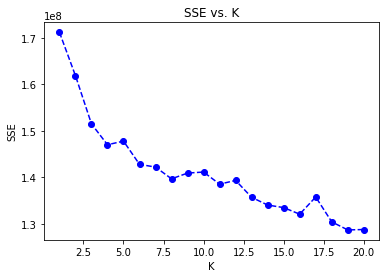

In [67]:
nb_clusters = 20 # TODO: Try with 20
# Over a number of different cluster counts...
scores = []
centers = list(range(1,nb_clusters+1))
for center in centers:

    # run k-means clustering on the data and...
    # compute the average within-cluster distances.
    scores.append(get_kmeans_score(data_transformed, center))

# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.    
# Plot the score against k
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');
    

In [64]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
#instantiate kmeans
center = 12
kmeans_final = MiniBatchKMeans(n_clusters=center)

# Then fit the model to your data using the fit method
model = kmeans_final.fit(data_transformed)

predicted_data = model.predict(data_transformed)


### Discussion 3.1: Apply Clustering to General Population
By increasing the number of clusters, the kmeans score decreases as it should be. Unfortunately, no clear elbow can be seen. In order to prevent the clusters from becoming too small and detailed, a final cluster number of 12 has been set.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [65]:
# Load in the customer demographics data.
# Data has already been loaded at the beginning, it is redone here for easier testing
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", delimiter = ";", header = 0)
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", delimiter=";")

In [83]:
# Cell is used to check if there are any missing columns in one of the processed data sets
#clean_customers, customers_below_threshold = clean_data(customers, feat_info)
# Compare columns
#for column in data_transformed.columns:
#    if column not in clean_customers.columns:
#        print("Column missing in customers: ", column)
#for column in clean_customers.columns:
#    if column not in data_transformed.columns:
#        print("column missing in data: ", column)

In [66]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
#print(type(data_transformed.columns))


# Part 1 - Preprocess data
clean_customers, customers_below_threshold = clean_data(customers, feat_info)

# Part 2 - Feature Transformation
print("Shape of clean customers: ", clean_customers.shape)
clean_customers = apply_feature_scaling(scaler, clean_customers, clean_customers.columns)

# Part 3 - Clustering
predicted_customers = kmeans_final.predict(clean_customers)
# Add removed data as additional cluster
print(predicted_customers)


Original Shape:  (191652, 85)
<TITEL_KZ>
<AGER_TYP>
<KK_KUNDENTYP>
<KBA05_BAUMAX>
<GEBURTSJAHR>
<ALTER_HH>
Final Shape:  (191652, 79)
 Original shape of data: (191652, 79)
3 data rows have been dropped as they contained less than 32 data entries. 
In total, there are 191649 rows for further calculations.
Number of used features per data type: 
ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64
Original shape: (191649, 79)
adding Gebauedetyp_5.0, length:  (191649, 6)
Shape after adding dummy_variables: (191649, 192)
Original shape: (3, 79)
adding Gebauedetyp_5.0, length:  (3, 0)
Shape after adding dummy_variables: (3, 66)
Shape of clean customers:  (191649, 192)
192
replace_NaNs_by_mean - begin:  (191649, 192)
replace_NaNs_by_mean - end: (191649, 192)
(191649, 192)


/home/meli/miniconda3/envs/env-conda-3-7/lib/python3.6/site-packages/ipykernel_launcher.py:17: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.


[10  0  1 ... 10  1 11]


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [67]:
## Add Labels to dataset
tmp = {'labels': predicted_data.tolist()}
labels_data = pd.DataFrame(data= tmp)
predicted_data = pd.concat([data, labels_data], axis=1)

tmp = {'labels': predicted_customers.tolist()}
labels_customers = pd.DataFrame(data=tmp)
predicted_customers = pd.concat([clean_customers, labels_customers], axis=1)

In [68]:
## Add data with few datapoints as additional cluster
max_labels = np.maximum(data_below_threshold.shape[0], customers_below_threshold.shape[0])
labels_list=[]
labels_list = labels_list + [-1]*(max_labels - len(labels_list))

labels_cluster_data_dict = {'labels': labels_list[:data_below_threshold.shape[0]]}
labels_cluster_data = pd.DataFrame(data=labels_cluster_data_dict)
print(labels_cluster_data)
predicted_data = pd.concat([predicted_data, labels_cluster_data], ignore_index=True)

labels_cluster_dict = {'labels': labels_list[:data_below_threshold.shape[0]]}
labels_cluster = pd.DataFrame(data=labels_cluster_dict)
predicted_customers = pd.concat([predicted_customers, labels_cluster], ignore_index=True)

   labels
0      -1
1      -1
2      -1


/home/meli/miniconda3/envs/env-conda-3-7/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':
/home/meli/miniconda3/envs/env-conda-3-7/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  del sys.path[0]


In [69]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
print("Predicted Cluster| Ratio (data)| Ratio (customers)")
cnt_data_labels, cnt_data_counts = np.unique(predicted_data.labels, return_counts = True)
cnt_customers_labels, cnt_customers_counts = np.unique(predicted_customers.labels, return_counts = True)


for i in range(-1, center): 
    print("{:17d}|{:13f}|{:18f}".format(i,
                            (cnt_data_counts[i]/predicted_data.shape[0])*100,
                           (cnt_customers_counts[i]/predicted_customers.shape[0])*100))

Predicted Cluster| Ratio (data)| Ratio (customers)
               -1|    11.152677|          8.211237
                0|     0.000337|          0.001565
                1|     3.743292|         11.879866
                2|    10.258735|         11.290777
                3|    13.784909|          5.142133
                4|     8.310733|          2.663682
                5|     8.599438|          1.347755
                6|     3.294132|          3.261119
                7|     3.088684|          1.312274
                8|     8.530432|         24.359255
                9|     4.099881|          2.637593
               10|    14.696243|          1.074343
               11|    10.440508|         26.818400


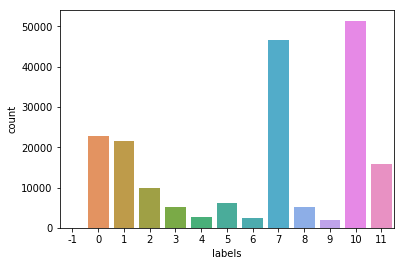

In [70]:
sns.countplot(predicted_customers.labels)

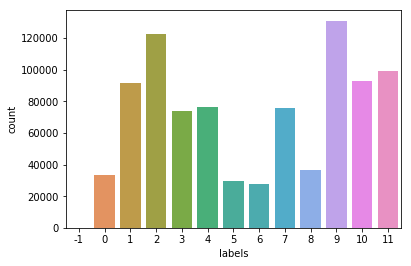

In [71]:
sns.countplot(predicted_data.labels)

In [72]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
# In this execution, cluster 4 and 7 are over represented in the customer dataset

display(pd.DataFrame(kmeans_final.cluster_centers_).T.iloc[:3, [3, 6]])
print("Cluster 4 is mostly influenced by the first principal component."\
      "The first component describes the region rather than a personality. "\
      "The region has the strongest influence on the first component. There "\
      "are many multi-family houses there ( PLZ8_ANTG3, PLZ8_ANTG4, KBA05_ANTG3,"\
      "KBA05_ANTG4). In addition, the people are concerned about their money (FINANZ_SPARER, FINANZ_MINIMALIST).\n")

print("Cluster 7 is mostly influenced by the third principal component. "\
      "The personality that matches the third component is responsible "\
      "and dutiful (SEMIO_PFLICHT, FINANZ_VORSORGER). In addition, this "\
      "person is culturally interested and adheres to traditions (SEMIO_TRADV, "\
      "SEMIO_KULT). Shopping does it rather situation-specific (SEMIO_ERL).")

print("As a conclusion, it can be said that customers tend to come from heavily "\
      "built-up areas. In addition, these people pay attention to their money.")


# This discussion helped a lot by solving this task
# https://study-hall.udacity.com/sg-474340-2087/rooms/community:nd025:474340-cohort-2087-project-1973/community:thread-4680348671-337579?contextType=room

,3,6
0,-0.983706,-0.410944
1,-0.312796,-0.015642
2,0.174369,-0.424087


Cluster 4 is mostly influenced by the first principal component.The first component describes the region rather than a personality. The region has the strongest influence on the first component. There are many multi-family houses there ( PLZ8_ANTG3, PLZ8_ANTG4, KBA05_ANTG3,KBA05_ANTG4). In addition, the people are concerned about their money (FINANZ_SPARER, FINANZ_MINIMALIST).

Cluster 7 is mostly influenced by the third principal component. The personality that matches the third component is responsible and dutiful (SEMIO_PFLICHT, FINANZ_VORSORGER). In addition, this person is culturally interested and adheres to traditions (SEMIO_TRADV, SEMIO_KULT). Shopping does it rather situation-specific (SEMIO_ERL).
As a conclusion, it can be said that customers tend to come from heavily built-up areas. In addition, these people pay attention to their money.


In [73]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
# In this execution, cluster 5 and 11 are under represented in the customer dataset
display(pd.DataFrame(kmeans_final.cluster_centers_).T.iloc[:3, [4, 10]])
print("Cluster 5 is mostly influenced by the first and third principal component. "\
      "since the signs of the components are inverted in comparison to the overrepresented "\
      "clusters, it seems as if these persons are the opposite. this means, among other things, "\
      "that they live in lightly-built areas.\n")
print("Cluster 11 is mostly influenced by the second principal component. "\
      "The second component is influenced by the estimated income of the household "\
      "and the place of residence (HH_EINKOMMEN_SCORE, ORTSGR_KLS9). As a general "\
      "rule, the area is rather lightly built on (KBA05_ANTG1) and the age of the "\
      "building is important (MIN_GEBAEUDEJAHR).")


,4,10
0,-0.527925,0.614385
1,0.222074,0.024319
2,-0.681437,1.084226


Cluster 5 is mostly influenced by the first and third principal component. since the signs of the components are inverted in comparison to the overrepresented clusters, it seems as if these persons are the opposite. this means, among other things, that they live in lightly-built areas.

Cluster 11 is mostly influenced by the second principal component. The second component is influenced by the estimated income of the household and the place of residence (HH_EINKOMMEN_SCORE, ORTSGR_KLS9). As a general rule, the area is rather lightly built on (KBA05_ANTG1) and the age of the building is important (MIN_GEBAEUDEJAHR).


### Discussion 3.3: Compare Customer Data to Demographics Data

The description of the influecing factors can be found below the code cells.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.